In [2]:
#Program Name: hw4.ipynb
#Date Created: November 15th, 2022
#Author: Deepesh Verma (dbv293)

In [3]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

Velocity field data has shape: (375, 64, 32, 2)


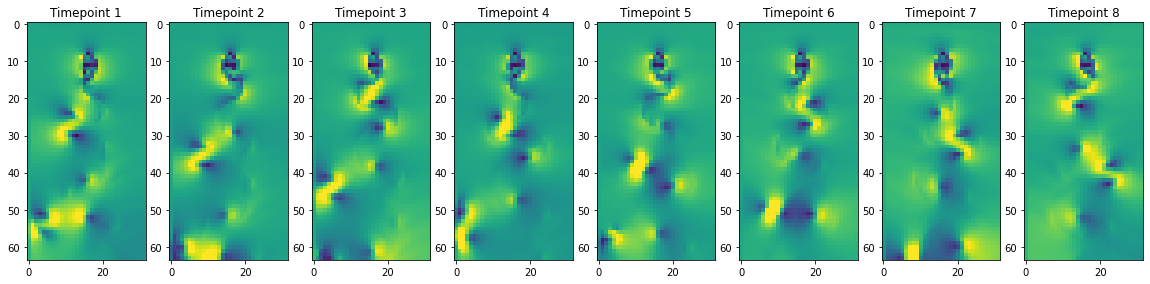

In [4]:
## Load the velocity field data

Re = 600 # Reynolds number, change this to 300, 600, 900, 1200

# Load the two-dimensional velocity field data. Data is stored in a 4D numpy array,
# where the first dimension is the time index, the second and third dimensions are the
# x and y coordinates, and the fourth dimension is the velocity components (ux or uv).
vfield = np.load(
    f"/Users/deepesh.b.verma/documents/grad/grad4/fall2022/phy381c/hw2/vortex_street_velocities_Re_1200_largefile.npz", 
    allow_pickle=True
)
# downsample the data for faster training
vfield = vfield[::8, ::4, ::4]
print("Velocity field data has shape: {}".format(vfield.shape))

# Compute the velocity magnitude
vfield_mag = np.sqrt(vfield[..., 0]**2 + vfield[..., 1]**2)

n_tpts = vfield.shape[0]
plt.figure(figsize=(20, 10))
for i in range(8):
    plt.subplot(1, 8, i+1)
    v_vals = vfield_mag[n_tpts // 8 * i]
    plt.imshow(v_vals, cmap="viridis", vmin=0, vmax=np.percentile(v_vals, 99))
    plt.title("Timepoint {}".format(i + 1))

In [5]:
class ForecastingDataset:
    """
    A class for formatting time series data for forecasting.
    By convention, time is assumed to be the first dimension of the dataset.

    For time series data, it is very important that all data in test set is after 
    all data in the train and val sets. We also need to ensure that datapoints don't
    appear in multiple splits. 

    Parameters
        X (np.ndarray): The time series data. The first dimension is assumed to be time.
        split_ratio (tuple): The ratio of the data to be used for train, val, and test.
        forecast_horizon (int): The number of time steps to forecast at once
        featurizer (callable): A function that takes in multivariate snapshot and 
            returns a feature vector. If None, the raw data is used.
    """

    def __init__(self, X, split_ratio=(0.6, 0.2, 0.2), forecast_horizon=1, featurizer=None):

        if featurizer is None:
            self.featurizer = lambda x: x
        else:
            self.featurizer = featurizer

        self.feature_shape = X.shape[1:]

        # We need to ensure that datapoints don't appear in multiple splits, hence why
        # we crop by the forecast horizon. We are going to do one-step forecasting
        self.X_full = self.featurizer(X[:-1])#[:-forecast_horizon]
        self.y_full = X[1:]#[forecast_horizon:]
        self.forecast_horizon = forecast_horizon

        # Split the data into train, val, test
        n_train = int(len(self.X_full) * split_ratio[0])
        n_val = int(len(self.X_full) * split_ratio[1])
        n_test = len(self.X_full) - n_train - n_val

        # Our frequent use of the forecast_horizon parameter again arises from our need
        # to ensure that datapoints don't appear in multiple splits.
        self.X_train, self.y_train = self.X_full[:n_train], self.y_full[:n_train]
        self.X_val, self.y_val = (
            self.X_full[n_train + forecast_horizon : n_train + forecast_horizon + n_val], 
            self.y_full[n_train+ forecast_horizon : n_train + forecast_horizon + n_val]
        )
        self.X_test, self.y_test = (
            self.X_full[n_train + 2 * forecast_horizon+ n_val:], 
            self.y_full[n_train + 2 * forecast_horizon + n_val:]
        )

    def __len__(self):
        return len(self.X_full)

    def __getitem__(self, idx):
        return self.X_full[idx], self.y_full[idx]

    def flatten_data(self, x):
        """
        Given a dataset, transform into a flat feature form
        """
        return np.reshape(x, (x.shape[0], -1))

    def unflatten_data(self, x):
        """
        Given a flat dataset, convert back to the original shape
        """
        out = np.reshape(x, (x.shape[0], *self.feature_shape))
        return out



# Let's do a simple unit test to make sure that our class is working as expected
# Take some time to understand what these test cases cover
import unittest
class TestForecastingDataset(unittest.TestCase):
    def test_initialization(self):
        fd = ForecastingDataset(np.arange(100)[:, None])
        assert fd.y_train[0] == fd.X_train[1], "y_train is not shifted by 1 from X_train"
        assert fd.y_val[0] == fd.X_val[1], "y_val is not shifted by 1 from X_val"
        assert fd.y_test[0] == fd.X_test[1], "y_test is not shifted by 1 from X_test"
        
        assert fd.y_train[-1] < fd.y_val[0], "y_train and y_test are not disjoint"
        assert fd.y_val[-1] < fd.y_test[0], "y_val and y_test are not disjoint"

unittest.main(argv=[''], exit=False);

.
----------------------------------------------------------------------
Ran 1 test in 0.010s

OK


In [9]:
import warnings 

class BaseRegressor:
    """
    A base class for regression models.
    """
    def __init__(self):
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        """
        Fits the model to the data.
        """
        raise NotImplementedError("Subclasses must implement this method")

    def predict(self, X):
        return X @ self.weights + self.bias

    def score(self, X, y):
        """
        Returns the mean squared error of the model.
        """
        return np.mean((self.predict(X) - y)**2)

class LinearRegressor(BaseRegressor):
    """
    A linear regression model is a linear function of the form:
    y = w0 + w1 * x1 + w2 * x2 + ... + wn * xn
    The weights are the coefficients of the linear function.
    The bias is the constant term w0 of the linear function.
    Attributes:
        method: str, optional. The method to use for fitting the model.
        regularization: str, optional. The type of regularization to use.
    """
    
    def __init__(self, method="global", regularization="ridge", regstrength=0.1, **kwargs):
        super().__init__(**kwargs)
        self.method = method
        self.regularization = regularization
        self.regstrength = regstrength

    # functions that begin with underscores are private, by convention.
    # Technically we could access them from outside the class, but we should
    # not do that because they can be changed or removed at any time.
    def _fit_global(self, X, y):
        """
        Fits the model using the global least squares method.
        """
        if self.regularization is None:
            self.weights = np.linalg.inv(X.T @ X) @ X.T @ y
        elif self.regularization == "ridge":
            self.weights = np.linalg.inv(X.T @ X + np.eye(X.shape[1]) * self.regstrength) @ X.T @ y
        else:
            warnings.warn("Unknown regularization method, defaulting to None")
            self.weights = np.linalg.inv(X.T @ X) @ X.T @ y
        self.bias = np.mean(y - X @ self.weights)
        return self.weights, self.bias

    def _fit_iterative(self, X, y, learning_rate=0.01):
        """
        Fit the model using gradient descent.
        """
        self.weights = np.zeros((X.shape[1], X.shape[1]))
        self.bias = np.mean(y)
        for i in range(X.shape[0]):
            self.weights += learning_rate * (y[i] - X[i] @ self.weights - self.bias) * X[i] - self.regstrength * self.weights
        self.weights /= X.shape[0]
        return self.weights, self.bias

    def fit(self, X, y):
        """
        Fits the model to the data. The method used is determined by the
        `method` attribute.
        """
        if self.method == "global":
            out = self._fit_global(X, y)
        elif self.method == "iterative":
            out = self._fit_iterative(X, y)
        else:
            out = self._fit_global(X, y)
        return out

def featurize_flowfield(field):
    """
    Compute features of a 2D spatial field. These features are chosen based on the 
    intuition that the input field is a 2D spatial field with time translation 
    invariance.
    The output is an augmented feature along the last axis of the input field.
    Args:
        field (np.ndarray): A 3D array of shape (batch, nx, ny) containing the flow field
    Returns:
        field_features (np.ndarray): A 3D array of shape (batch, nx, ny, M) containing 
            the computed features stacked along the last axis
    """
    ## Compute the Fourier features
    field_fft = np.fft.fft2(field)
    field_fft = np.fft.fftshift(field_fft)
    field_fft_abs = np.log(np.abs(field_fft) + 1e-8)[..., None]
    field_fft_phase = np.angle(field_fft)[..., None]

    ## Compute the spatial gradients along x and y
    field_grad = np.gradient(field, axis=(-2, -1))
    field_grad = np.stack(field_grad, axis=-1)

    ## Compute the spatial Laplacian
    field_lap = np.stack(np.gradient(field_grad, axis=(-2, -1)), axis=-1)
    field_lap = np.sum(field_lap, axis=-1)

    field = field[..., None]
    field_features = np.concatenate(
        [field, field_grad, field_lap, field_fft_phase, field_fft_abs], 
        axis=-1
    )
    return field_features



Text(0.5, 0, 'Time step')

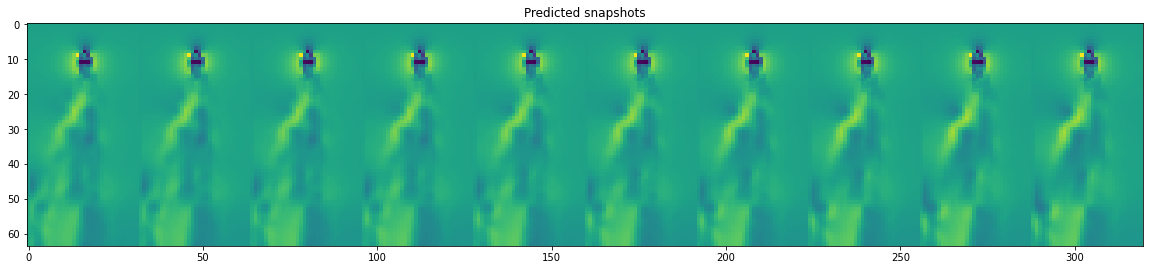

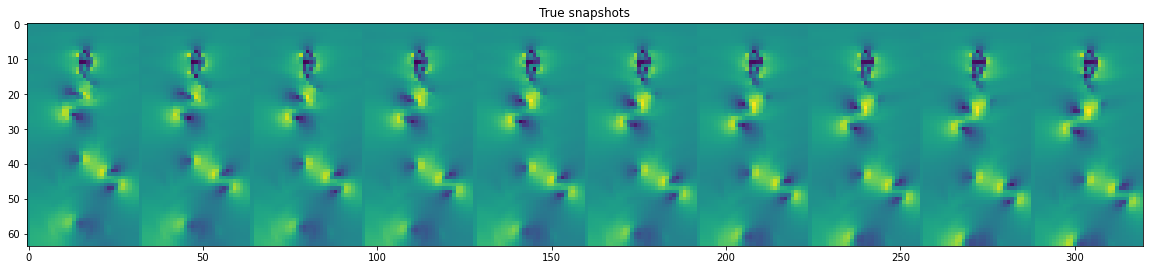

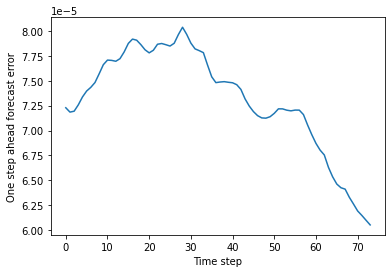

In [10]:
#Testing

# Automatically split the data into train, validation, and test sets
dataset= ForecastingDataset(vfield_mag)

# Initialize the model
model = LinearRegressor(method="global", regularization="ridge", regstrength=1.0)

model.fit(
    dataset.flatten_data(dataset.X_train), 
    dataset.flatten_data(dataset.y_train)
)

y_test_pred = dataset.unflatten_data(
    model.predict(dataset.flatten_data(dataset.X_test))
)

plt.figure(figsize=(20, 10))
plt.imshow(np.hstack(y_test_pred[::3][-10:]))
plt.title("Predicted snapshots")

plt.figure(figsize=(20, 10))
plt.imshow(np.hstack(dataset.y_test[::3][-10:]))
plt.title("True snapshots")


mse_vs_time = np.mean((y_test_pred - dataset.y_test)**2, axis=(1, 2))
plt.figure()
plt.plot(mse_vs_time)
plt.ylabel("One step ahead forecast error")
plt.xlabel("Time step")

In [11]:
#Hyperparameter Training 
regstrengths = np.logspace(-4, 4, 9)

all_mse = []
for regstrength in regstrengths:
    print(f"Training model with regstrength={regstrength}", flush=True)

    model = LinearRegressor(method="global", regularization="ridge", regstrength=regstrength)

    model.fit(
        dataset.flatten_data(dataset.X_train), 
        dataset.flatten_data(dataset.y_train)
    )

    y_val_pred = dataset.unflatten_data(
        model.predict(dataset.flatten_data(dataset.X_val))
    )

    mse = np.mean((y_val_pred - dataset.y_val)**2)
    all_mse.append(mse)

best_regstrength = regstrengths[np.argmin(np.array(all_mse))]

print(f"Best regularize strength: {best_regstrength}")

Training model with regstrength=0.0001
Training model with regstrength=0.001
Training model with regstrength=0.01
Training model with regstrength=0.1
Training model with regstrength=1.0
Training model with regstrength=10.0
Training model with regstrength=100.0
Training model with regstrength=1000.0
Training model with regstrength=10000.0
Best regularize strength: 0.0001


Text(0.5, 0, 'Time step')

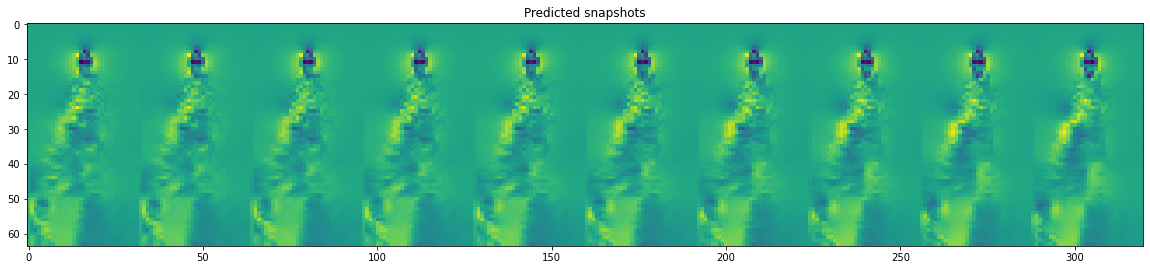

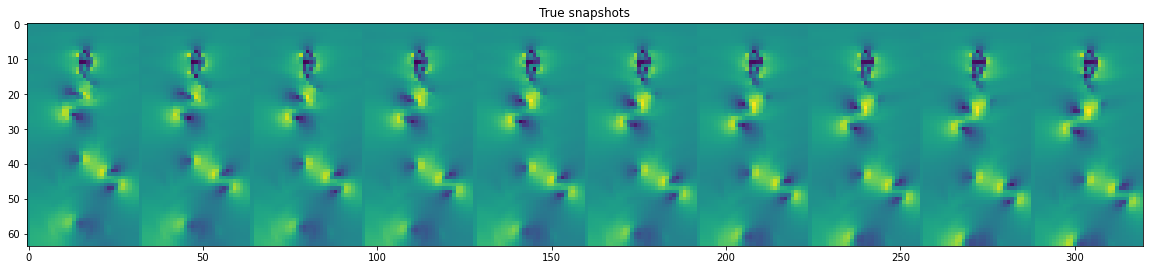

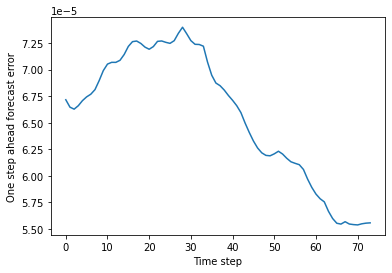

In [12]:
model = LinearRegressor(method="global", regularization="ridge", regstrength=best_regstrength)

model.fit(
    dataset.flatten_data(dataset.X_train), 
    dataset.flatten_data(dataset.y_train)
)

y_test_pred = dataset.unflatten_data(
    model.predict(dataset.flatten_data(dataset.X_test))
)

plt.figure(figsize=(20, 10))
plt.imshow(np.hstack(y_test_pred[::3][-10:]))
plt.title("Predicted snapshots")

plt.figure(figsize=(20, 10))
plt.imshow(np.hstack(dataset.y_test[::3][-10:]))
plt.title("True snapshots")

mse_vs_time = np.mean((y_test_pred - dataset.y_test)**2, axis=(1, 2))
plt.figure()
plt.plot(mse_vs_time)
plt.ylabel("One step ahead forecast error")
plt.xlabel("Time step")

Text(0.5, 1.0, 'Ground truth')

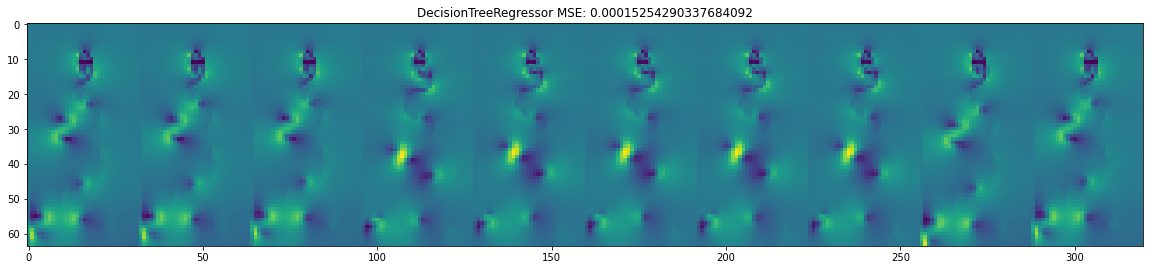

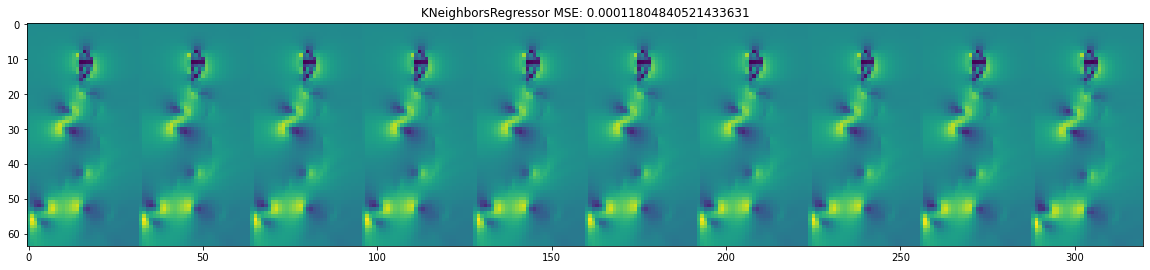

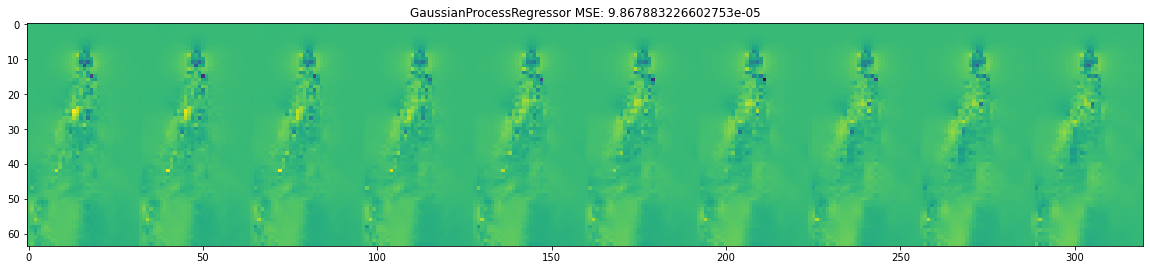

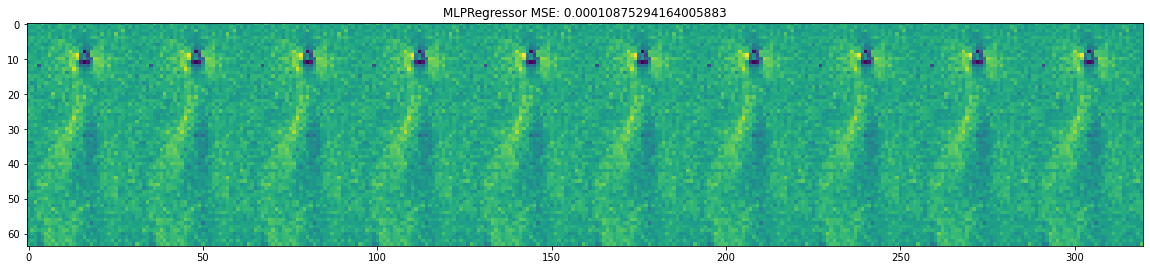

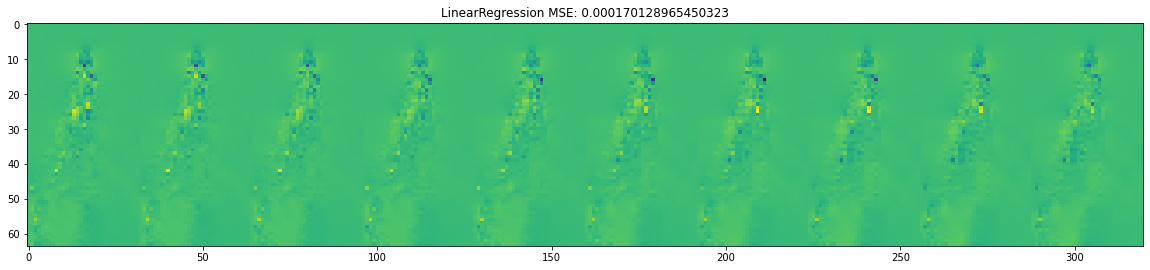

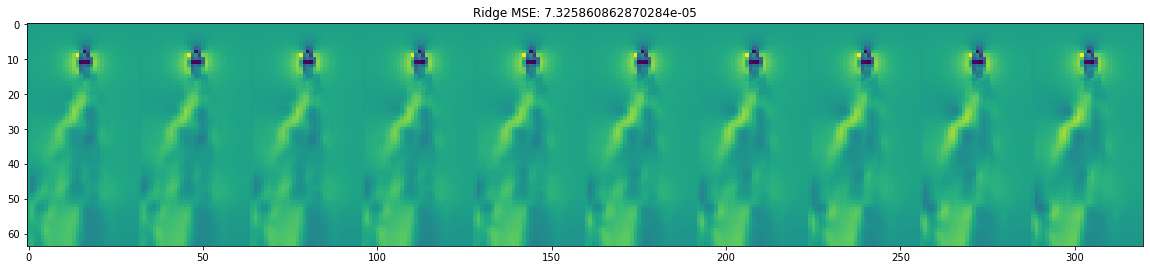

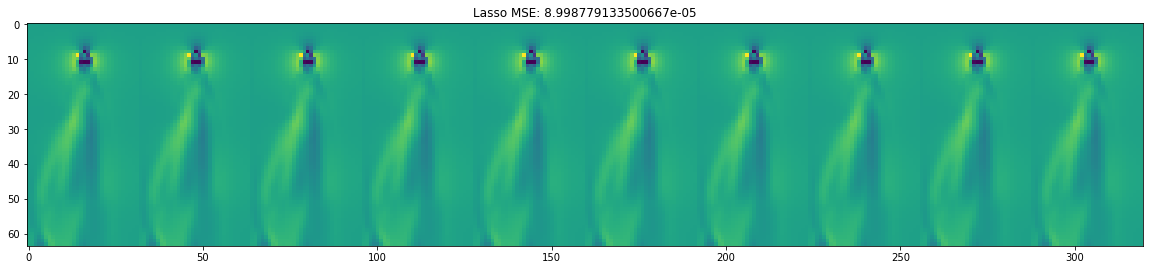

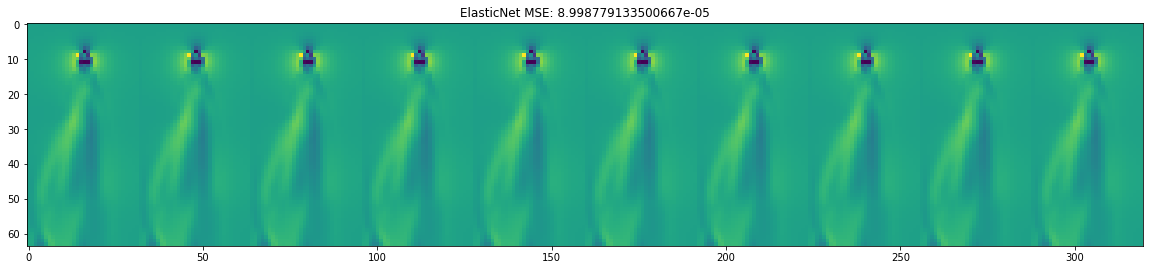

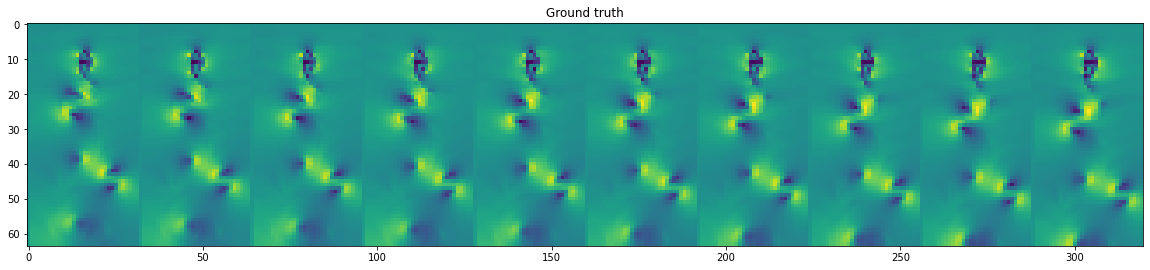

In [13]:
#Different Regression Models
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor

for model in [DecisionTreeRegressor(), KNeighborsRegressor(), 
                GaussianProcessRegressor(), MLPRegressor(), 
                LinearRegression(), Ridge(), Lasso(), ElasticNet()
            ]:

    name = type(model).__name__
    model.fit(
        dataset.flatten_data(dataset.X_train), 
        dataset.flatten_data(dataset.y_train)
    )

    y_test_pred = dataset.unflatten_data(
        model.predict(
            dataset.flatten_data(dataset.X_test)
        )
    )
    mse = np.mean((y_test_pred - dataset.y_test)**2)

    plt.figure(figsize=(20, 10))
    plt.imshow(np.hstack(y_test_pred[::3][-10:]))
    plt.title(name + " " + f"MSE: {mse}")

plt.figure(figsize=(20, 10))
plt.imshow(np.hstack(dataset.y_test[::3][-10:]))
plt.title("Ground truth")